In [1]:
import numpy as np


In [78]:
## Plotting methods
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter

## Publication-like style for latex in matplotlib
plt.rcParams["font.family"] = "stix"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"]  = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15


In [73]:
##############################
import sph_jeans.sph_jeans as sph
import sph_jeans.extended_dark_mass_models as dm

In [4]:
import sph_jeans.dyn_fit_iso as dyn_fit_iso

In [5]:
import corner

In [6]:
from tqdm import tqdm

## DATA

In [7]:
PRF2D  = np.load('DATA_BHS/PRF-BHS-model.npy')
PRF3D  = np.load('DATA_BHS/PRF-INT-BHS-model.npy')
bstLUM = np.load('DATA_BHS/BEST-BHS-model.npy')

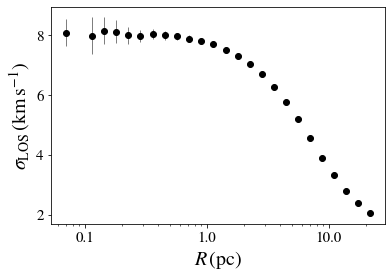

In [79]:
fig,axs = plt.subplots(1,1)

axs.errorbar(PRF2D[0,0],PRF2D[6,0],yerr=[PRF2D[6,1],PRF2D[6,2]],fmt='ok',lw=0.5)

axs.set_xscale('log')

axs.set_xlabel(r'$R\,(\rm pc)$')
axs.set_ylabel(r'$\sigma_{\rm LOS}\,(\rm km\,\rm s^{-1})$')
axs.xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))

################################################
plt.show()


## MCMC FIT

In [9]:
data_fit   = [PRF2D[0,0],PRF2D[6,0],np.amax(PRF2D[6,1:],axis=0)]

### (a) Only STARS

In [10]:
init_guess_str = np.array([1.0]) 

In [11]:
str_sample_chain,str_lnlike_chain = dyn_fit_iso.fit_jeans_str(bstLUM, data_fit,init_guess_str,n_walkers = 20, n_steps = 1000, progress=True)

100%|██████████| 1000/1000 [07:04<00:00,  2.36it/s]


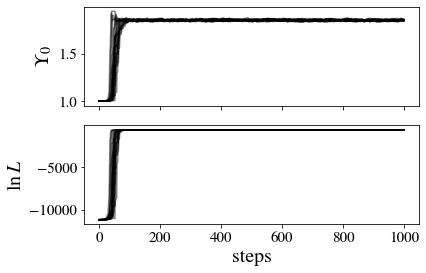

In [80]:
fig,axs = plt.subplots(2,1,figsize=(6,(str_samples.shape[1]+1)*2),sharex=True)

for k in range(str_sample_chain.shape[0]):
    axs[0].plot(str_sample_chain[k,:,0],'-k',alpha=0.5)
    #axs[1].plot(str_sample_chain[k,:,1],'-k',alpha=0.5)
    axs[1].plot(str_lnlike_chain[k,:],'-k',alpha=0.5)

    
axs[0].set_ylabel(r'$\Upsilon_0$')
#axs[1].set_ylabel(r'$\beta$')
axs[1].set_ylabel(r'$\ln L$')
axs[1].set_xlabel(r'steps')


################
plt.show()

In [81]:
n_burn = 400 

str_samples = str_sample_chain[:,n_burn:,:].reshape((-1,str_sample_chain.shape[2]))
str_loglike = str_lnlike_chain[:,n_burn:].reshape((-1))


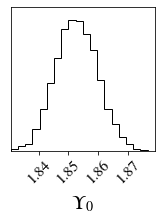

In [82]:
fig = corner.corner(str_samples,labels=[r'$\Upsilon_0$',r'$\beta$'])

In [83]:
n_mods = 300
r_mods = np.logspace(-1.5,1.5,20)

In [84]:
str_idx_choice = np.random.choice(range(str_samples.shape[0]),size=n_mods,replace=False)

In [17]:
str_mods = np.zeros((n_mods,2,r_mods.size))

modSTR = sph.model(bstLUM)
modSTR.gen_nu()

lumSTR = modSTR.I_surf(r_mods)


for k in tqdm(range(n_mods)):
    aux_ml = str_samples[str_idx_choice[k]]
    
    modSTR.gen_mass(aux_ml,0.0)
    modSTR.gen_vdisp(0.0)
    
    str_mods[k,1] = modSTR.get_mass_tot(r_mods)
    str_mods[k,0] = modSTR.s_los(r_mods)
    
    

100%|██████████| 300/300 [00:06<00:00, 49.01it/s]


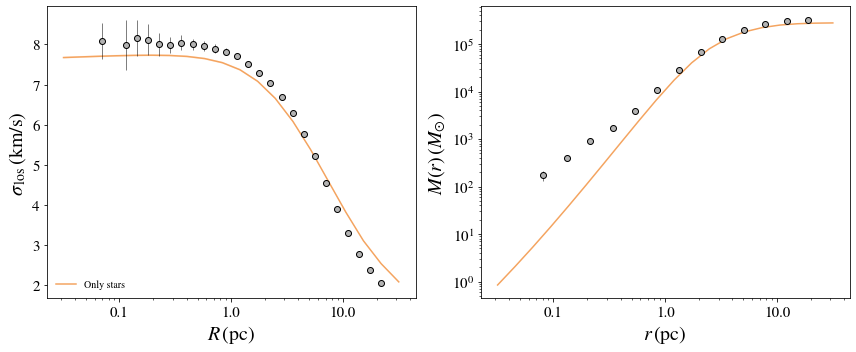

In [88]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

## STR
axs[0].plot(r_mods,str_mods[0,0],'-',c='sandybrown', label = 'Only stars')
axs[0].fill_between(r_mods,np.percentile(str_mods[:,0],5,axis=0),np.percentile(str_mods[:,0],95,axis=0),color='peachpuff',edgecolor='none',alpha=0.5)

axs[1].plot(r_mods,str_mods[0,1],'-',c='sandybrown')
axs[1].fill_between(r_mods,np.percentile(str_mods[:,1],5,axis=0),np.percentile(str_mods[:,1],95,axis=0),color='peachpuff',edgecolor='none',alpha=0.5)

### data
axs[0].errorbar(PRF2D[0,0],PRF2D[6,0],yerr=[PRF2D[6,1],PRF2D[6,2]],fmt='ok',mfc='0.7',lw=0.5)
axs[1].errorbar(PRF3D[0,0],PRF3D[15,0],yerr=PRF3D[15,1],fmt='ok',mfc='0.7',lw=0.5)

###
axs[0].legend(frameon=False,loc=3)

###
axs[0].set_xlabel(r'$R\,(\rm pc)$',fontsize=20)
axs[0].set_ylabel(r'$\sigma_{\rm\,los}\,(\rm km/\rm s)$',fontsize=20)

axs[1].set_xlabel(r'$r\,(\rm pc)$',fontsize=20)
axs[1].set_ylabel(r'$M(r)\,(M_{\odot})$',fontsize=20)

###
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))

###
fig.tight_layout()
plt.show()

In [101]:
best_ML = str_samples[np.argmax(str_loglike)]

print('Best ML = %4.3lf Mo/Lo'%(best_ML))

Best ML = 1.853 Mo/Lo


### (b) Plummer

In [20]:
init_guess_dm = np.array([0.5,3.0]) 

In [21]:
plu_sample_chain,plu_lnlike_chain = dyn_fit_iso.fit_jeans_dm(bstLUM, data_fit,init_guess_dm, best_ML,dm.dm_density_plummer, n_walkers = 20, n_steps = 1000, progress=True)

100%|██████████| 1000/1000 [09:22<00:00,  1.78it/s]


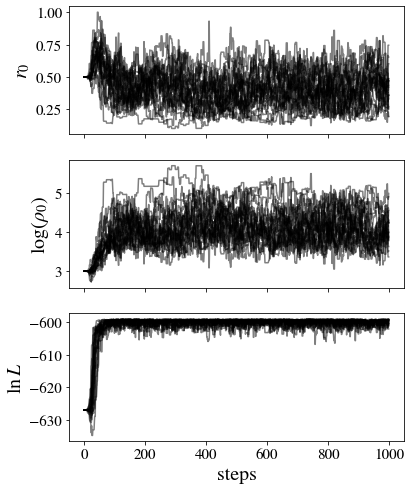

In [89]:
fig,axs = plt.subplots(3,1,figsize=(6,8),sharex=True)

for k in range(plu_sample_chain.shape[0]):
    axs[0].plot(plu_sample_chain[k,:,0],'-k',alpha=0.5)
    axs[1].plot(plu_sample_chain[k,:,1],'-k',alpha=0.5)
    axs[2].plot(plu_lnlike_chain[k,:],'-k',alpha=0.5)

axs[0].set_ylabel(r'$r_0$')
axs[1].set_ylabel(r'$\log(\rho_0)$')
axs[2].set_ylabel(r'$\ln L$')
axs[2].set_xlabel(r'steps')

plt.show()


In [23]:
plu_samples = plu_sample_chain[:,800:,:].reshape((-1,plu_sample_chain.shape[2]))
plu_loglike = plu_lnlike_chain[:,800:].reshape((-1))

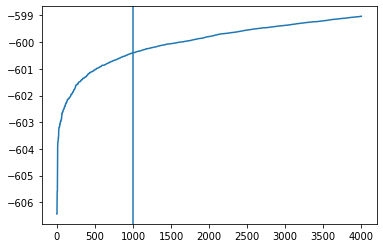

In [24]:
## chains cleaning 
plt.plot(np.sort(plu_loglike))
plt.axvline(x=1000)
plu_idx_loglike = np.argsort(plu_loglike)[1000:]


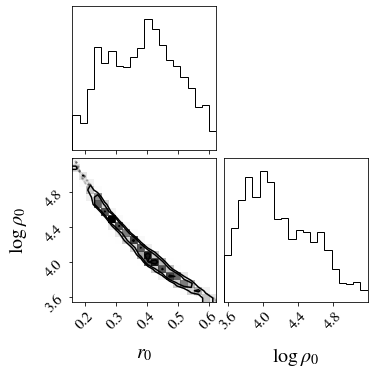

In [90]:
fig = corner.corner(plu_samples[plu_idx_loglike],labels=[r'$r_0$',r'$\log \rho_0$'])

In [26]:
plu_idx_choice = np.zeros(n_mods+1).astype(int)
plu_idx_choice[0]  = np.argmax(plu_loglike)
plu_idx_choice[1:] = np.random.choice(plu_idx_loglike,size=n_mods,replace=False)

In [28]:
plu_mods = np.zeros((n_mods+1,2,r_mods.size))
plu_pars = np.zeros((n_mods+1,plu_samples.shape[1]+1))
plu_chi2 = np.zeros(n_mods+1)

modPLU = sph.model(bstLUM)
modPLU.gen_nu()

for k in tqdm(range(n_mods+1)):
    aux_r0,aux_logp0 = plu_samples[plu_idx_choice[k]]
    
    plu_pars[k,:-1] =  plu_samples[plu_idx_choice[k]]
    plu_pars[k,-1]  =  plu_loglike[plu_idx_choice[k]]
    
    
    modPLU.gen_mass_with_dm(best_ML,0.0,dm.dm_density_plummer,10**aux_logp0,aux_r0)
    modPLU.gen_vdisp(0.0)
    
    plu_mods[k,1] = modPLU.get_mass_tot(r_mods)
    plu_mods[k,0] = modPLU.s_los(r_mods)
    
    ##############################
    plu_chi2[k] = np.sum((data_fit[1]-np.interp(data_fit[0],r_mods,plu_mods[k,0]))**2/data_fit[2]**2)
    

100%|██████████| 301/301 [00:08<00:00, 34.17it/s]


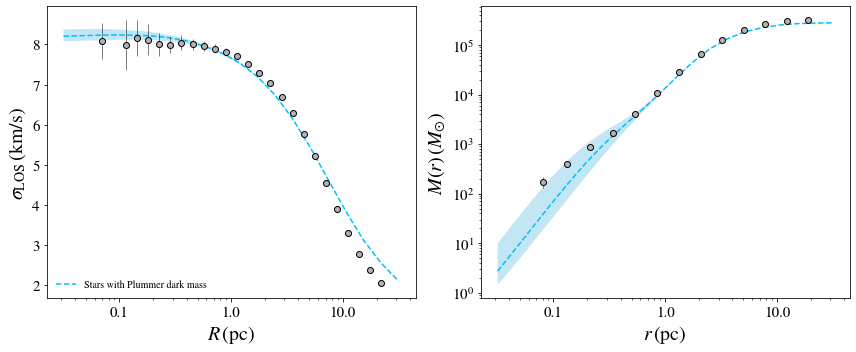

In [93]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

## PLU
axs[0].plot(r_mods,plu_mods[0,0],'--',c='deepskyblue',label='Stars with Plummer dark mass')
axs[0].fill_between(r_mods,np.percentile(plu_mods[:,0],5,axis=0),np.percentile(plu_mods[:,0],95,axis=0),color='skyblue',edgecolor='none',alpha=0.5)

axs[1].plot(r_mods,plu_mods[0,1],'--',c='deepskyblue')
axs[1].fill_between(r_mods,np.percentile(plu_mods[:,1],5,axis=0),np.percentile(plu_mods[:,1],95,axis=0),color='skyblue',edgecolor='none',alpha=0.5)

### data
axs[0].errorbar(PRF2D[0,0],PRF2D[6,0],yerr=[PRF2D[6,1],PRF2D[6,2]],fmt='ok',mfc='0.7',lw=0.5)
axs[1].errorbar(PRF3D[0,0],PRF3D[15,0],yerr=PRF3D[15,1],fmt='ok',mfc='0.7',lw=0.5)

###
axs[0].legend(frameon=False,loc=3)

###
axs[0].set_xlabel(r'$R\,(\rm pc)$',fontsize=20)
axs[0].set_ylabel(r'$\sigma_{\rm LOS}\,(\rm km/\rm s)$',fontsize=20)

axs[1].set_xlabel(r'$r\,(\rm pc)$',fontsize=20)
axs[1].set_ylabel(r'$M(r)\,(M_{\odot})$',fontsize=20)

###
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))

###
fig.tight_layout()
plt.show()

### (c) NFW

In [32]:
init_guess_dm = np.array([0.5,3.0]) 

In [33]:
nfw_sample_chain,nfw_lnlike_chain = dyn_fit_iso.fit_jeans_dm(bstLUM, data_fit,init_guess_dm,best_ML, dm.dm_density_nfw, n_walkers = 20, n_steps = 1000, progress=True)

100%|██████████| 1000/1000 [08:03<00:00,  2.07it/s]


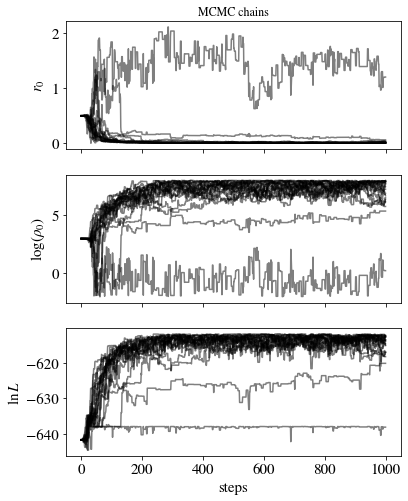

In [94]:
fig,axs = plt.subplots(3,1,figsize=(6,8),sharex=True)

for k in range(nfw_sample_chain.shape[0]):
    axs[0].plot(nfw_sample_chain[k,:,0],'-k',alpha=0.5)
    axs[1].plot(nfw_sample_chain[k,:,1],'-k',alpha=0.5)
    axs[2].plot(nfw_lnlike_chain[k,:],'-k',alpha=0.5)

    
axs[0].set_ylabel(r'$r_0$',fontsize=15)
axs[1].set_ylabel(r'$\log(\rho_0)$',fontsize=15)
axs[2].set_ylabel(r'$\ln L$',fontsize=15)
axs[2].set_xlabel(r'steps',fontsize=15)
axs[0].set_title('MCMC chains')

plt.show()


In [37]:
nfw_samples = nfw_sample_chain[:,800:,:].reshape((-1,nfw_sample_chain.shape[2]))
nfw_loglike = nfw_lnlike_chain[:,800:].reshape((-1))

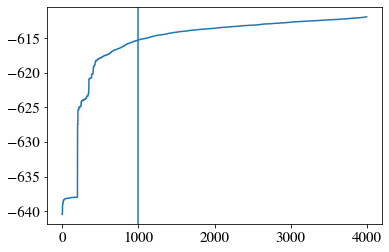

In [95]:
plt.plot(np.sort(nfw_loglike))
plt.axvline(x=1000)
nfw_idx_loglike = np.argsort(nfw_loglike)[1000:]

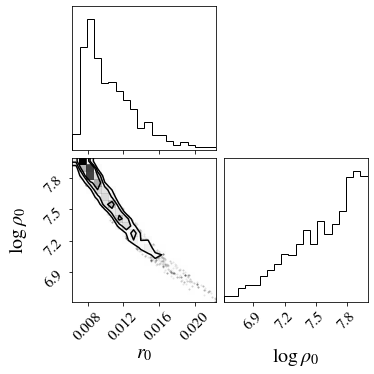

In [96]:
fig = corner.corner(nfw_samples[nfw_idx_loglike],labels=[r'$r_0$',r'$\log \rho_0$'])

In [40]:
nfw_idx_choice = np.zeros(n_mods+1).astype(int)
nfw_idx_choice[0]  = np.argmax(nfw_loglike)
nfw_idx_choice[1:] = np.random.choice(nfw_idx_loglike,size=n_mods,replace=False)

In [41]:
nfw_mods = np.zeros((n_mods+1,2,r_mods.size))
nfw_pars = np.zeros((n_mods+1,nfw_samples.shape[1]+1))
nfw_chi2 = np.zeros(n_mods+1)

modNFW = sph.model(bstLUM)
modNFW.gen_nu()

for k in tqdm(range(n_mods+1)):
    aux_r0,aux_logp0 = nfw_samples[nfw_idx_choice[k]]
    
    nfw_pars[k,:-1] =  nfw_samples[nfw_idx_choice[k]]
    nfw_pars[k,-1]  =  nfw_loglike[nfw_idx_choice[k]]
    
    
    modNFW.gen_mass_with_dm(best_ML,0.0,dm.dm_density_nfw,10**aux_logp0,aux_r0)
    modNFW.gen_vdisp(0.0)
    
    nfw_mods[k,1] = modNFW.get_mass_tot(r_mods)
    nfw_mods[k,0] = modNFW.s_los(r_mods)
    
    ##############################
    nfw_chi2[k] = np.sum((data_fit[1]-np.interp(data_fit[0],r_mods,nfw_mods[k,0]))**2/data_fit[2]**2)
    

100%|██████████| 301/301 [00:09<00:00, 30.33it/s]


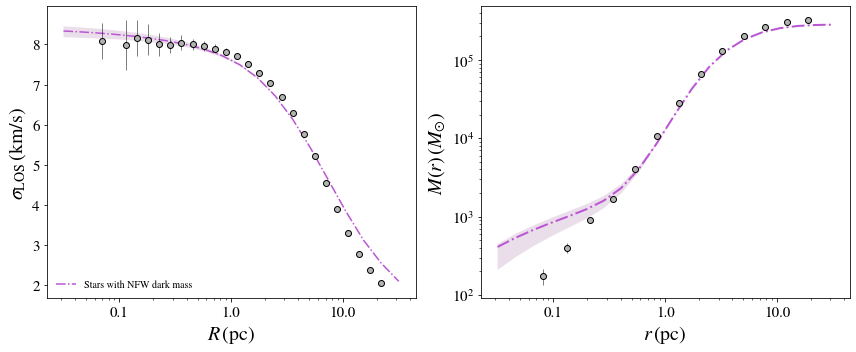

In [98]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

## NFW
axs[0].plot(r_mods,nfw_mods[0,0],'-.',c='mediumorchid',label='Stars with NFW dark mass')
axs[0].fill_between(r_mods,np.percentile(nfw_mods[:,0],5,axis=0),np.percentile(nfw_mods[:,0],95,axis=0),color='thistle',edgecolor='none',alpha=0.5)

axs[1].plot(r_mods,nfw_mods[0,1],'-.',c='mediumorchid',lw=2)
axs[1].fill_between(r_mods,np.percentile(nfw_mods[:,1],5,axis=0),np.percentile(nfw_mods[:,1],95,axis=0),color='thistle',edgecolor='none',alpha=0.5)

### data
axs[0].errorbar(PRF2D[0,0],PRF2D[6,0],yerr=[PRF2D[6,1],PRF2D[6,2]],fmt='ok',mfc='0.7',lw=0.5)
axs[1].errorbar(PRF3D[0,0],PRF3D[15,0],yerr=PRF3D[15,1],fmt='ok',mfc='0.7',lw=0.5)

###
axs[0].legend(frameon=False,loc=3)

###
axs[0].set_xlabel(r'$R\,(\rm pc)$',fontsize=20)
axs[0].set_ylabel(r'$\sigma_{\rm LOS}\,(\rm km/\rm s)$',fontsize=20)

axs[1].set_xlabel(r'$r\,(\rm pc)$',fontsize=20)
axs[1].set_ylabel(r'$M(r)\,(M_{\odot})$',fontsize=20)

###
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))

###
fig.tight_layout()
plt.show()

## COMPARISON

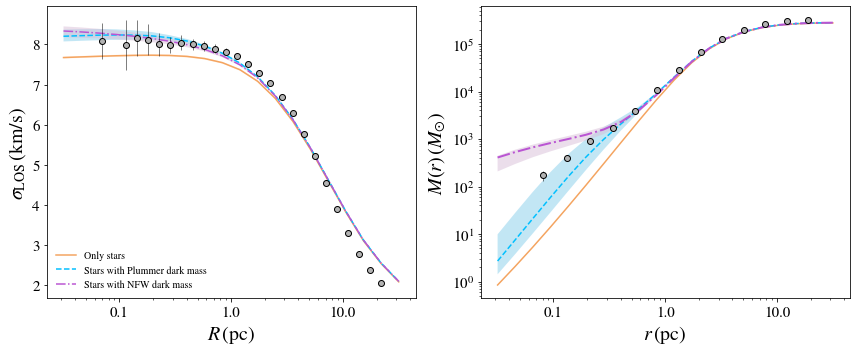

In [99]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

## STR
axs[0].plot(r_mods,str_mods[0,0],'-',c='sandybrown', label = 'Only stars')
axs[0].fill_between(r_mods,np.percentile(str_mods[:,0],5,axis=0),np.percentile(str_mods[:,0],95,axis=0),color='peachpuff',edgecolor='none',alpha=0.5)

axs[1].plot(r_mods,str_mods[0,1],'-',c='sandybrown')
axs[1].fill_between(r_mods,np.percentile(str_mods[:,1],5,axis=0),np.percentile(str_mods[:,1],95,axis=0),color='peachpuff',edgecolor='none',alpha=0.5)


## PLU
axs[0].plot(r_mods,plu_mods[0,0],'--',c='deepskyblue',label='Stars with Plummer dark mass')
axs[0].fill_between(r_mods,np.percentile(plu_mods[:,0],5,axis=0),np.percentile(plu_mods[:,0],95,axis=0),color='skyblue',edgecolor='none',alpha=0.5)

axs[1].plot(r_mods,plu_mods[0,1],'--',c='deepskyblue')
axs[1].fill_between(r_mods,np.percentile(plu_mods[:,1],5,axis=0),np.percentile(plu_mods[:,1],95,axis=0),color='skyblue',edgecolor='none',alpha=0.5)

## NFW
axs[0].plot(r_mods,nfw_mods[0,0],'-.',c='mediumorchid',label='Stars with NFW dark mass')
axs[0].fill_between(r_mods,np.percentile(nfw_mods[:,0],5,axis=0),np.percentile(nfw_mods[:,0],95,axis=0),color='thistle',edgecolor='none',alpha=0.5)

axs[1].plot(r_mods,nfw_mods[0,1],'-.',c='mediumorchid',lw=2)
axs[1].fill_between(r_mods,np.percentile(nfw_mods[:,1],5,axis=0),np.percentile(nfw_mods[:,1],95,axis=0),color='thistle',edgecolor='none',alpha=0.5)

### data
axs[0].errorbar(PRF2D[0,0],PRF2D[6,0],yerr=[PRF2D[6,1],PRF2D[6,2]],fmt='ok',mfc='0.7',lw=0.5)
axs[1].errorbar(PRF3D[0,0],PRF3D[15,0],yerr=PRF3D[15,1],fmt='ok',mfc='0.7',lw=0.5)

###
axs[0].legend(frameon=False,loc=3)

###
axs[0].set_xlabel(r'$R\,(\rm pc)$',fontsize=20)
axs[0].set_ylabel(r'$\sigma_{\rm LOS}\,(\rm km/\rm s)$',fontsize=20)

axs[1].set_xlabel(r'$r\,(\rm pc)$',fontsize=20)
axs[1].set_ylabel(r'$M(r)\,(M_{\odot})$',fontsize=20)

###
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%3.1lf'))

###
fig.tight_layout()
plt.show()